In [2]:
import os
import numpy as np

## Preprocessing Pipeline

In [ ]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

output_dir = r".\Datasets\Alzeimehers\Sliced"
os.makedirs(output_dir, exist_ok=True)

img_path = r".\Datasets\Alzeimehers\OAS1_0001_MR1_mpr-1_anon\OAS1_0001_MR1_mpr-1_anon.img"  
img = nib.load(img_path)

data = img.get_fdata()
print(f"MRI data shape: {data.shape}")

def normalize_to_uint8(data):
    data = np.nan_to_num(data, nan=0, posinf=0, neginf=0)
    data_min = np.min(data)
    data_max = np.max(data)
    
    if data_min == data_max:
        return np.zeros_like(data, dtype=np.uint8)
    
    normalized = ((data - data_min) / (data_max - data_min) * 255)
    return normalized.astype(np.uint8)

def is_empty_slice(slice_data, threshold=0.02):
    slice_normalized = slice_data / (np.max(data) + 1e-10)
    
    if np.max(slice_normalized) < threshold:
        return True
    
    meaningful_pixels = np.sum(slice_normalized > threshold/5) / slice_data.size
    if meaningful_pixels < 0.05:  
        return True
        
    if np.std(slice_normalized) < threshold/10:
        return True
        
    return False

axes = ['axial', 'coronal', 'sagittal']
for axis_idx, axis_name in enumerate(axes):
    axis_dir = os.path.join(output_dir, axis_name)
    os.makedirs(axis_dir, exist_ok=True)
    
    n_slices = data.shape[axis_idx]
    
    first_valid_slice = 0
    last_valid_slice = n_slices - 1
    
    for i in range(n_slices):
        if axis_idx == 0:
            slice_data = data[i, :, :]
        elif axis_idx == 1:
            slice_data = data[:, i, :]
        else:
            slice_data = data[:, :, i]
            
        if not is_empty_slice(slice_data):
            first_valid_slice = i
            break
    
    for i in range(n_slices - 1, -1, -1):
        if axis_idx == 0:
            slice_data = data[i, :, :]
        elif axis_idx == 1:
            slice_data = data[:, i, :]
        else:
            slice_data = data[:, :, i]
            
        if not is_empty_slice(slice_data):
            last_valid_slice = i
            break
    
    print(f"{axis_name}: Using slices {first_valid_slice} to {last_valid_slice} (skipping {first_valid_slice} slices at start, {n_slices - last_valid_slice - 1} at end)")
    
    slice_count = 0
    for slice_idx in range(first_valid_slice, last_valid_slice + 1):
        if axis_idx == 0:
            slice_data = data[slice_idx, :, :]
        elif axis_idx == 1:
            slice_data = data[:, slice_idx, :]
        else:
            slice_data = data[:, :, slice_idx]
        
        if is_empty_slice(slice_data):
            continue
            
        slice_normalized = normalize_to_uint8(slice_data)
        slice_normalized = np.squeeze(slice_normalized)
        
        plt.figure(figsize=(10, 10), frameon=False)
        plt.imshow(slice_normalized, cmap='gray')
        plt.axis('off')
        plt.tight_layout(pad=0)
        output_path = os.path.join(axis_dir, f'slice_{slice_count:04d}.png')
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0, dpi=100)
        plt.close()
        
        slice_count += 1
    
    print(f"Saved {slice_count} non-empty {axis_name} slices to {axis_dir}")

print(f"All slices have been extracted and saved to: {output_dir}")

MRI data shape: (256, 256, 128, 1)
axial: Using slices 15 to 222 (skipping 15 slices at start, 33 at end)
Saved 208 non-empty axial slices to C:\Users\LENOVO\Desktop\Python\Datasets\Alzeimehers\Sliced\axial
coronal: Using slices 27 to 226 (skipping 27 slices at start, 29 at end)
Saved 200 non-empty coronal slices to C:\Users\LENOVO\Desktop\Python\Datasets\Alzeimehers\Sliced\coronal
sagittal: Using slices 1 to 127 (skipping 1 slices at start, 0 at end)
Saved 127 non-empty sagittal slices to C:\Users\LENOVO\Desktop\Python\Datasets\Alzeimehers\Sliced\sagittal
All slices have been extracted and saved to: C:\Users\LENOVO\Desktop\Python\Datasets\Alzeimehers\Sliced


## Dataset Preparation

In [ ]:
alzeihmers = r'.\Datasets\Alzeimehers\Data'
stages = ["Mild Dementia", "Moderate Dementia", "Non Demented", "Very mild Dementia"]

In [3]:
num_samples = 0

for folders in os.listdir(alzeihmers):
    path =  os.path.join(alzeihmers, folders)
    print(f"{folders} : {len(os.listdir(path))}")
    num_samples += len(os.listdir(path))
    

Mild_Dementia : 5002
Moderate_Dementia : 488
Non_Demented : 67222
Very_mild_Dementia : 13725


In [4]:
import tensorflow as tf

In [5]:
train_generator = tf.keras.utils.image_dataset_from_directory(
    alzeihmers,
    image_size=(120, 120),
    batch_size=None,  
    subset='training',
    validation_split=0.2,
    seed=56
) 

val_generator = tf.keras.utils.image_dataset_from_directory(
    alzeihmers,
    image_size=(120, 120),
    batch_size=None,  
    subset='validation',
    validation_split=0.2,
    seed=56
)  

Found 86437 files belonging to 4 classes.
Using 69150 files for training.
Found 86437 files belonging to 4 classes.
Using 17287 files for validation.


In [6]:
print(train_generator.class_names)

['Mild_Dementia', 'Moderate_Dementia', 'Non_Demented', 'Very_mild_Dementia']


In [7]:
def one_hot_encode(image, label):
    num_classes = 4
    label = tf.one_hot(label, depth=num_classes)
    return image, label

In [8]:
train_generator = train_generator.map(one_hot_encode) \
                                .batch(64) 

val_generator = val_generator.map(one_hot_encode) \
                            .batch(64)

## Model Training

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(shape=(120, 120, 3)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 120, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 118, 118, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 57, 57, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,769,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,862,788 (10.92 MB)

 Trainable params: 2,862,788 (10.92 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate= 1e-4),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy', 'precision', 'recall']
)

In [12]:
class_weights =  {0: 10, 1: 25, 2: 1, 3: 3}

In [ ]:
model.fit(train_generator,
          validation_data=val_generator,
          epochs=10,
          callbacks=[lr],
          class_weight=class_weights)

## Model Performance

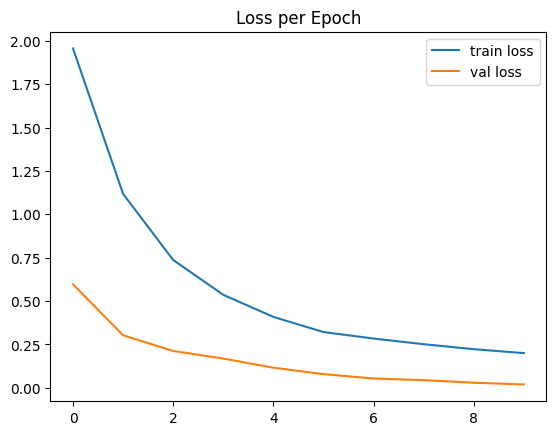

In [19]:
import matplotlib.pyplot as plt

plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.legend(['train loss', 'val loss'])
plt.title('Loss per Epoch');

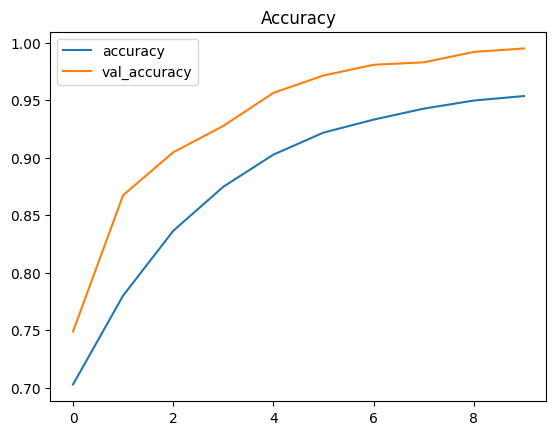

In [20]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('Accuracy');

In [ ]:
model.save('fit.h5')